In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/NLP_Capgemini_2021/NLP @ X_HEC - 2K21/Final/")

In [53]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import io
import os
import re
import nltk
import ast
import tqdm
import itertools
import sklearn
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.corpus import wordnet
from textblob import TextBlob
from datetime import datetime
from string import punctuation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from ast import literal_eval
from sklearn import decomposition
from sklearn.utils import class_weight
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# NLP Libraries
import gensim
from gensim.test.utils import get_tmpfile
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Define parameters for notebook import
%matplotlib inline
pd.set_option('display.max_columns', 500)

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

tqdm.tqdm_notebook()
tqdm.notebook.tqdm().pandas()

DATAPATH = "data/"

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
# Try to name your data / dataframe explicitly. 
df = pd.read_csv(DATAPATH+"bokan.csv", usecols=range(1,6))

In [5]:
#Remove stop words
stop_words = nltk.corpus.stopwords.words('english')
stop_list = ['th', 'bokan', 'london', 'canary', 'wharf', 'novotel']

for word in stop_list:
  stop_words.append(word)

def remove_stop_words(text):
    tokens = word_tokenize(text)
    tokens = [x.lower() for x in tokens]
    return ' '.join([i for i in tokens if not i in stop_words])

In [6]:
#Lemmatizing
lemmatizer = WordNetLemmatizer()

#function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

#Lemmatize with tags
def lemmatize_sentence(sentence):
    #find the POS tag for each word
    tokens = word_tokenize(sentence)
    nltk_tagged = nltk.pos_tag(tokens)  
    
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag in [wordnet.NOUN, wordnet.ADJ, wordnet.ADV, wordnet.VERB]:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
   
    return lemmatized_sentence

In [7]:
#basic cleaning
def basic_cleaning(text):
  tokens = word_tokenize(text)

  #Remove numbers
  tokens = [re.sub(r'\d+', '', x) for x in tokens]

  #Remove ’s, ’t
  tokens = [x.replace('’s', '').replace('’t', '') for x in tokens]

  #Remove empty strings
  text = ' '.join([i for i in tokens if i != ''])
  
  return text

In [8]:
df['review_text_clean'] = df['review_text'].apply(lambda x: remove_stop_words(x))
df['review_text_clean'] = df['review_text_clean'].apply(lambda x: basic_cleaning(x))
df['review_sentences'] = df['review_text_clean'].apply(lambda x: nltk.sent_tokenize(x))
df['review_text_clean'] = df['review_text_clean'].apply(lambda x: lemmatize_sentence(x))

In [9]:
df.head()

,resto,review_rating,review_text,review_link,source,review_text_clean,review_sentences
0,BOKAN 38 Bar & 39 Rooftop,2,This place has potential but it has one the mo...,https://www.tripadvisor.co.uk/ShowUserReviews-...,Tripadvisor,"[place, potential, unwelcoming, entrance, come...",[place potential one unwelcoming entrances com...
1,BOKAN 38 Bar & 39 Rooftop,5,"Wow, where do I start, we had the most amazing...",https://www.tripadvisor.co.uk/ShowUserReviews-...,Tripadvisor,"[wow, start, amaze, evening, host, florian, ’,...","[wow , start , amazing evening , hosted floria..."
2,BOKAN 38 Bar & 39 Rooftop,5,"Whenever you visit London, Canary Wharf, you j...",https://www.tripadvisor.co.uk/ShowUserReviews-...,Tripadvisor,"[visit, go, roofbar, beer, drink, snack, always]","[whenever visit , , go roofbar , beer , drink ..."
3,BOKAN 38 Bar & 39 Rooftop,5,"Terrific view, service & atmosphere. The resta...",https://www.tripadvisor.co.uk/ShowUserReviews-...,Tripadvisor,"[terrific, view, service, atmosphere, restaura...","[terrific view , service & atmosphere ., resta..."
4,BOKAN 38 Bar & 39 Rooftop,2,I am coming very often at Bokan with my friend...,https://www.tripadvisor.co.uk/ShowUserReviews-...,Tripadvisor,"[come, often, friends, always, great, experien...",[coming often friends always great experience ...


In [74]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

plate_mask = 255 - np.array(Image.open(DATAPATH+"plate.png"))

In [ ]:
def from_corpus_to_word_cloud(df):
  stword = stop_words
  text = " ".join(review_text for review_text in df)
  wordcloud = WordCloud(background_color="white", stopwords=stword, mask=plate_mask, width=800, height=400).generate(text)

  plt.figure(figsize=(20,15))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

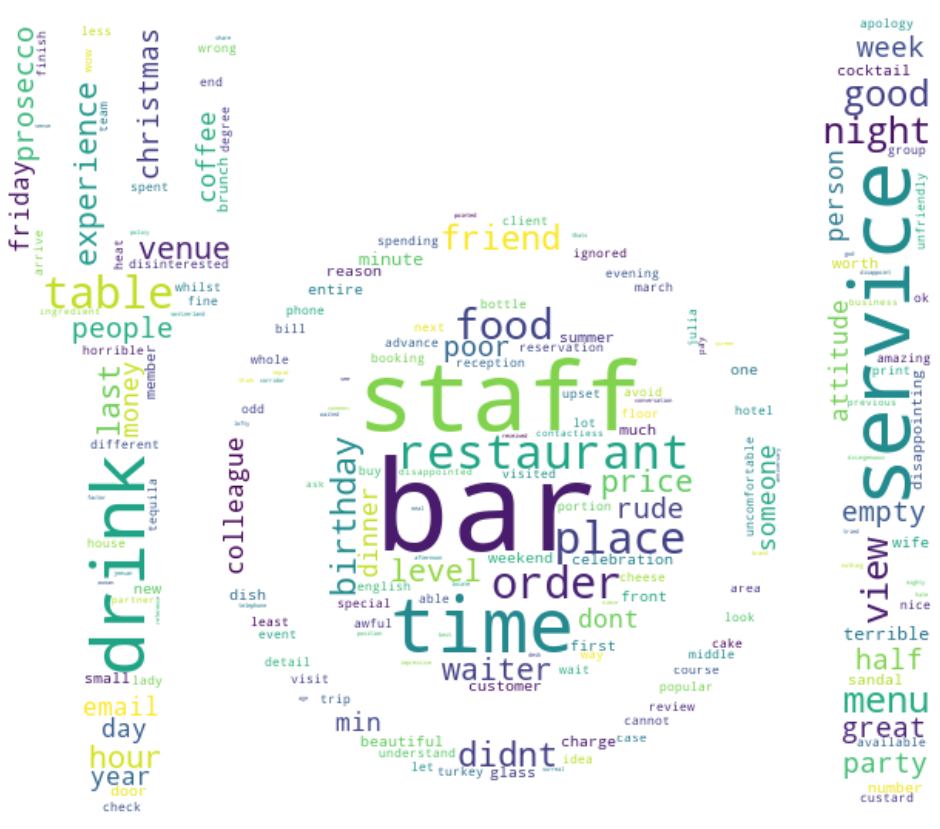

In [ ]:
corpus = [x for sub in df[df['review_rating']==1]['review_text_clean'] for x in sub]
from_corpus_to_word_cloud(corpus)

In [ ]:
path = get_tmpfile("w2v_all.model")
corpus = resto.review_text_clean
model_all = gensim.models.Word2Vec(size=300, window=3, min_count=5, workers=4, seed=1, iter=50)
model_all.build_vocab(corpus)
model_all.train(corpus, total_examples=model_all.corpus_count, epochs=model_all.iter)
model_all.save("w2v_all.model")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


In [ ]:
df1 = df[df['review_rating']<=2]

In [ ]:
path = get_tmpfile("word2vec.model")
corpus = df.review_text_clean
model = gensim.models.Word2Vec(size=300, window=3, min_count=5, workers=4, seed=1, iter=50)
model.build_vocab(corpus)
model.train(corpus, total_examples=model.corpus_count, epochs=model.iter)
model.save("word2vec.model")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


In [ ]:
common_words = []
for tup in model.wv.most_similar("charge", topn=100):
  common_words.append(tup[0])

In [ ]:
[x[0] for x in nltk.pos_tag(common_words) if x[1]=='JJ'][:20]

['empty',
 'arrive',
 'long',
 '£',
 'poor',
 'sure',
 'table',
 'didnt',
 'wrong',
 'hostess',
 'understand',
 'full',
 'terrible',
 'lunch',
 'sunday',
 'first',
 'free',
 'overall',
 'crazy',
 'special']

In [ ]:
review_bad = [y for x in df['review_text_clean'] for y in x if y in common_words]

In [ ]:
from collections import Counter

wordcounts = Counter(review_bad)
wordcounts

Counter({'advance': 12,
         'anyone': 9,
         'anything': 9,
         'apology': 5,
         'arrive': 11,
         'ask': 11,
         'attention': 10,
         'attitude': 9,
         'bartender': 13,
         'beer': 12,
         'bill': 9,
         'booking': 5,
         'bottle': 18,
         'cannot': 14,
         'cant': 9,
         'celebrate': 9,
         'celebration': 10,
         'champagne': 7,
         'check': 6,
         'chip': 7,
         'coco': 5,
         'coffee': 16,
         'cold': 7,
         'crazy': 5,
         'customer': 25,
         'didnt': 36,
         'empty': 15,
         'enough': 5,
         'event': 6,
         'fine': 8,
         'first': 27,
         'free': 7,
         'front': 9,
         'full': 21,
         'get': 15,
         'glass': 27,
         'group': 18,
         'half': 9,
         'hostess': 10,
         'hour': 22,
         'im': 6,
         'jazz': 6,
         'job': 5,
         'kitchen': 9,
         'last': 35,
         

In [ ]:
def ambience(corpus):
  words = ['ambience', 'decor', 'light', 'vibe', 'atmosphere', 'music', 'loud']
  for w in words:
    if w in corpus:
      return 1

  return 0 

def menu(corpus):
  words = ['portion', 'dish', 'small', 'size', 'serving','menu','course']
  for w in words:
    if w in corpus:
      return 1

  return 0 

def veg(corpus):
  words = ['vegan','vegetarian','veg','veggie']
  for w in words:
    if w in corpus:
      return 1

  return 0 

df1['ambience'] = df1['review_text_clean'].apply(lambda x: ambience(x))
df1['menu'] = df1['review_text_clean'].apply(lambda x: menu(x))
df['veg'] = df['review_text_clean'].apply(lambda x: veg(x))
list(df1[df1['ambience']==1]['review_text'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


['I ve been for the first time there, nice view but if you want some food at the bar, the best is to order the food first and the the drinks later, cuz it may take a while (in my case took more than 20 mins for some fries), the music is soo loud, it s like u re in a club, you can’t even have a discussion with the friends.',
 'Nice view, good food, but extremely loud due to dinner party in the restaurant. At times, it was impossible to understand the people sitting in front of you. Very unfortunate, were looking forward to a nice dinner.',
 'I was taken there for my birthday. The restaurant was full until 9pm, and so we had to settle for the bar. The place was very dark, and finding the table was not the say (for me, anyway). The awful din emitted by a woman squealing into a microphone (they tell me that it is singing; but it has nothing in common with Covent Garden) was so loud because, apparently, it has to carry over three floors in the building. The occasional breaks which she and h

In [ ]:
embedding_matrix = dict()

for word in model.wv.vocab.keys():
    embedding_matrix[word] = list(model.wv[word]) # get numpy vector of a word (wv = word vector)

embedding_matrix = pd.DataFrame(embedding_matrix)

In [11]:
sentences = list(itertools.chain(*df["review_sentences"]))
print(f"Number of total sentences : {len(sentences)}")

Number of total sentences : 3171


In [16]:
# Define and fit tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=' ', char_level=False)
tokenizer.fit_on_texts(sentences)

sequences = tokenizer.texts_to_sequences(sentences) 
print(df["review_sentences"][0][0], sentences[0], sequences[0], sep="\n\n")

place potential one unwelcoming entrances come outside .

place potential one unwelcoming entrances come outside .

[13, 1510, 21, 1076, 1511, 75, 303, 1]


In [17]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed=42):
    # Elements of each training example are appended to these lists.
    targets, contexts, labels = [], [], []

    # Build the sampling table for vocab_size tokens.
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    # Iterate over all sequences (sentences) in dataset.
    for sequence in tqdm.notebook.tqdm(sequences):

        # Generate positive skip-gram pairs for a sequence (sentence).
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequence, 
            vocabulary_size=vocab_size,
            sampling_table=sampling_table,
            window_size=window_size,
            negative_samples=0
        )

        # Iterate over each positive skip-gram pair to produce training examples 
        # with positive context word and negative samples.
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1, 
                num_sampled=num_ns, 
                unique=True, 
                range_max=vocab_size, 
                seed=seed, 
                name="negative_sampling"
            )

            # Build context and label vectors (for one target word)
            negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)

            context = tf.concat([context_class, negative_sampling_candidates], 0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")

            # Append each element from the training example to global lists.
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

In [20]:
targets, contexts, labels = generate_training_data(
    sequences=sequences, 
    window_size=2, 
    num_ns=4, 
    vocab_size=max(tokenizer.index_word.keys())+1 # vocab size + 1 for padding
)

print(len(targets), len(contexts), len(labels))




9162 9162 9162


In [21]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [22]:
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset shapes: (((32,), (32, 5, 1)), (32, 5)), types: ((tf.int32, tf.int64), tf.int64)>


In [23]:
class Skipgram(tf.keras.Model):
    """Negative Sampling Skigpram implementation.

    ```python
    w2v = Skipgram(vocab_size=4096, embedding_dim=128)
    ````
    """
    def __init__(self, vocab_size, embedding_dim):
        """Skigpram class constructor.

        Parameters
        ----------
        vocab_size: int.
            Size of the vocabulary.

        embedding_dim: int.
            Dimension of trained word2vec Skipgram embeddings.

        """
        super(Skipgram, self).__init__()
        self.target_embedding = tf.keras.layers.Embedding(
            vocab_size, 
            embedding_dim,
            input_length=1,
            name="w2v_embedding",
        )
        self.context_embedding = tf.keras.layers.Embedding(
            vocab_size, 
            embedding_dim, 
            input_length=4+1, # number of negative samples = 4
            name="context_embedding",
        ) 
        self.dots = tf.keras.layers.Dot(axes=(3,2))
        self.flatten = tf.keras.layers.Flatten()

    def call(self, pair):
        """Model forward method.
        """
        target, context = pair
        we = self.target_embedding(target)
        ce = self.context_embedding(context)
        dots = self.dots([ce, we])
        
        return self.flatten(dots)

In [24]:
embedding_dim = 128

word2vec = Skipgram(vocab_size=max(tokenizer.index_word.keys())+1, embedding_dim=128)
word2vec.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [25]:
word2vec.fit(dataset, epochs=20)

Epoch 1/20
286/286 [==============================] - 3s 8ms/step - loss: 1.6091 - accuracy: 0.2039
Epoch 2/20
286/286 [==============================] - 2s 8ms/step - loss: 1.5628 - accuracy: 0.8598
Epoch 3/20
286/286 [==============================] - 2s 8ms/step - loss: 1.4206 - accuracy: 0.8793
Epoch 4/20
286/286 [==============================] - 2s 8ms/step - loss: 1.1665 - accuracy: 0.8880
Epoch 5/20
286/286 [==============================] - 2s 8ms/step - loss: 0.8749 - accuracy: 0.9198
Epoch 6/20
286/286 [==============================] - 2s 8ms/step - loss: 0.6190 - accuracy: 0.9416
Epoch 7/20
286/286 [==============================] - 2s 8ms/step - loss: 0.4291 - accuracy: 0.9632
Epoch 8/20
286/286 [==============================] - 2s 8ms/step - loss: 0.3030 - accuracy: 0.9780
Epoch 9/20
286/286 [==============================] - 2s 8ms/step - loss: 0.2208 - accuracy: 0.9855
Epoch 10/20
286/286 [==============================] - 2s 8ms/step - loss: 0.1690 - accuracy: 0.9926

In [26]:
pretrained_weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
pretrained_weights.shape

(3182, 128)

In [29]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for idx, word in tokenizer.index_word.items():
    
    vec = pretrained_weights[idx] # first idx is 1 : skip 0, it's padding.
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    
out_v.close()
out_m.close()

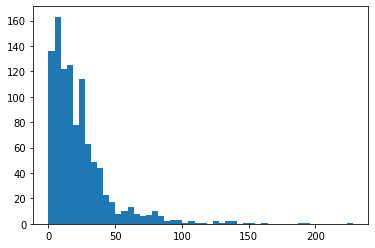

In [30]:
processed_review = [' '.join(rvw) for rvw in df["review_sentences"]] ### FILL THE BLANK ###
processed_sequences = tokenizer.texts_to_sequences(processed_review)

plt.hist([len(sequence) for sequence in processed_sequences], bins=50)
plt.show()

In [31]:
padded_processed_sequences = tf.keras.preprocessing.sequence.pad_sequences(processed_sequences, maxlen=180, padding="post")
padded_processed_sequences.shape

(1028, 180)

In [34]:
df['usable_rating'] = df['review_rating'].apply(lambda r: int(r)-1)
df.usable_rating.value_counts()

4    669
3    181
2     68
1     60
0     50
Name: usable_rating, dtype: int64

In [37]:
rating_labels = tf.keras.utils.to_categorical(df['usable_rating'], num_classes=5, dtype='float32')
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(padded_processed_sequences, rating_labels, test_size=0.3)

In [38]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

In [39]:
def review_preprocessing(review, words_maxlen=50, sentences_maxlen=10, tokenizer=tokenizer):
    """Preprocessing function to build appropriate padded sequences for HAN.

    Parameters
    ----------
    review: list.
        List of sentences (strings) of the review.
    
    words_maxlen: int.
        Maximal length/number of words for a sentence.

    sentences_maxlen: int.
        Maximal length/number of sentences for a review.

    Returns
    -------
    padded_sequences: tf.Tensor.
        Tensor of shape (sentences_maxlen, words_maxlen)
    """

    sequences = tokenizer.texts_to_sequences(review)
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=words_maxlen, padding="post")

    if padded_sequences.shape[0] < sentences_maxlen:
        padded_sequences = tf.pad(
            padded_sequences, 
            paddings=tf.constant([[0, sentences_maxlen-padded_sequences.shape[0]], [0, 0]])
        )
    elif padded_sequences.shape[0] > sentences_maxlen:
        padded_sequences = padded_sequences[:sentences_maxlen]

    assert padded_sequences.shape == (sentences_maxlen, words_maxlen)
    return padded_sequences

In [41]:
padded_preprocessed_reviews = [review_preprocessing(review) for review in tqdm.notebook.tqdm(df["review_sentences"])]
padded_preprocessed_reviews = tf.stack(padded_preprocessed_reviews)
padded_preprocessed_reviews.shape

TensorShape([1028, 10, 50])

In [42]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(padded_preprocessed_reviews.numpy(), rating_labels, test_size=0.3)
print(
    X_train.shape,
    X_test.shape, 
    y_train.shape, 
    y_test.shape,
    sep="\n"
)

(719, 10, 50)
(309, 10, 50)
(719, 5)
(309, 5)


In [43]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

In [44]:
class Attention(tf.keras.layers.Layer):
    """Attention mechanism used in "Hierarchical Attention Networks for Document Classification" paper.
        
    ```python
    attention_layer = Attention(units=64)
    ```
    """
    def __init__(self, units):
        """Attention layer constructor.

        Parameters
        ----------
        units: int.
            Dimension of the projection space.
        """
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.u = tf.keras.layers.Dense(1)

    def call(self, sequence):
        """Layer forward method.
        """
        attention_logits = self.u(tf.nn.tanh(self.W(sequence)))
        attention_weights = tf.nn.softmax(attention_logits, axis=-2)

        weighted_vectors = attention_weights * sequence
        context_vector = tf.reduce_sum(weighted_vectors, axis=-2)

        return context_vector, attention_weights

In [45]:
batch1 = tf.random.normal((16, 10, 50, 128))
batch2 = tf.random.normal((16, 10, 128))

attention = Attention(units=64)

(att_batch1, weights_batch1), (att_batch2, weights_batch2) = attention(batch1), attention(batch2)
print(att_batch1.shape, weights_batch1.shape)
print(att_batch2.shape, weights_batch2.shape)

(16, 10, 128) (16, 10, 50, 1)
(16, 128) (16, 10, 1)


In [46]:
from tensorflow.keras import regularizers
class HierarchicalAttentionNetwork(tf.keras.Model):
    """Hierarchical Attention Network implementation.

    Reference :
    * Hierarchical Attention Networks for Document Classification : https://www.cs.cmu.edu/~./hovy/papers/16HLT-hierarchical-attention-networks.pdf

    """
    def __init__(self, vocab_size, embedding_dim, gru_units, attention_units, classifier_units, pretrained_weights=None):
        """Hierarchical Attention Network class constructor.

        """
        super(HierarchicalAttentionNetwork, self).__init__()
        
        if pretrained_weights is not None:
            initializer = tf.keras.initializers.Constant(pretrained_weights)
        else:
            initializer = "uniform"

        self.embedding = tf.keras.layers.Embedding(
            vocab_size, 
            embedding_dim, 
            embeddings_initializer=initializer,
            mask_zero=True, ###masking
            trainable=True
        )
        self.WordGRU = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units=gru_units,
                activation="tanh",
                dropout=0.4,    ###Recurrent dropout
                kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-2),  ##regularization
                return_sequences=True
            ), 
            merge_mode='concat',
        )
        self.WordAttention = Attention(units=attention_units)
        self.SentenceGRU = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units=gru_units,
                activation="tanh",
                kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-2),  ##regularization
                dropout=0.4,    ###Recurrent dropout
                return_sequences=True
            ), 
            merge_mode='concat',
        )
        self.SentenceAttention = Attention(units=attention_units)
        self.fc = tf.keras.layers.Dense(units=classifier_units,kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-2),)##regularization
        self.dropout= tf.keras.layers.Dropout(rate=0.4)     ###Dropout layer

    def call(self, x):
        """Model forward method.
        """
        sentences_vectors, _ = self.word_to_sentence_encoder(x)
        document_vector, _ = self.sentence_to_document_encoder(sentences_vectors)
        return self.fc(document_vector)

    def word_to_sentence_encoder(self, x):
        """Given words from each sentences, 
           encode the contextual representation of the words from the sentence
           with Bidirectional GRU and Attention, and output a sentence_vector
        """
        x = self.embedding(x)
        x = tf.keras.layers.TimeDistributed(self.WordGRU)(x)
        x = self.dropout(x)   ###Dropout layer
        context_vector, attention_weights = self.WordAttention(x)

        return context_vector, attention_weights
    
    def sentence_to_document_encoder(self, sentences_vectors):
        sentences_vectors = self.SentenceGRU(sentences_vectors)
        sentences_vectors = self.dropout(sentences_vectors)   ###Dropout layer
        document_vector, attention_weights = self.SentenceAttention(sentences_vectors)
        
        return document_vector, attention_weights

In [47]:
han_model = HierarchicalAttentionNetwork(
    vocab_size=max(tokenizer.index_word.keys())+1, 
    embedding_dim=128, 
    pretrained_weights=pretrained_weights, 
    gru_units=32, 
    attention_units=32, 
    classifier_units=5
)

In [48]:
test_batch = tf.zeros((256, 10, 50))
test_output = han_model(test_batch)
test_output.shape

TensorShape([256, 5])

In [55]:
han_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=1e-2, from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
)

han_history = han_model.fit(
    train_ds, 
    epochs=20, 
    validation_data=test_ds,
    class_weight=dict(enumerate(df.usable_rating.value_counts().values / df.usable_rating.value_counts().values.sum())),
    callbacks=EarlyStopping(patience=5, restore_best_weights=True)
)

Epoch 1/20
23/23 [==============================] - 21s 439ms/step - loss: 0.1286 - accuracy: 0.6840 - val_loss: 1.0949 - val_accuracy: 0.6570
Epoch 2/20
23/23 [==============================] - 7s 290ms/step - loss: 0.1203 - accuracy: 0.7115 - val_loss: 1.1134 - val_accuracy: 0.6343
Epoch 3/20
23/23 [==============================] - 7s 292ms/step - loss: 0.1229 - accuracy: 0.6820 - val_loss: 1.4254 - val_accuracy: 0.5566
Epoch 4/20
23/23 [==============================] - 7s 288ms/step - loss: 0.1423 - accuracy: 0.6712 - val_loss: 1.3067 - val_accuracy: 0.5858
Epoch 5/20
23/23 [==============================] - 7s 287ms/step - loss: 0.1153 - accuracy: 0.6754 - val_loss: 1.4038 - val_accuracy: 0.5469
Epoch 6/20
23/23 [==============================] - 7s 292ms/step - loss: 0.1182 - accuracy: 0.6598 - val_loss: 1.5490 - val_accuracy: 0.5113


In [56]:
def evaluate_model(y_true, y_pred):
  print('F1 score (macro):', f1_score(y_true.argmax(axis=1), y_pred.argmax(axis=1), average='macro'))
  print('Precision score (macro):', precision_score(y_true.argmax(axis=1), y_pred.argmax(axis=1), average='macro'))
  print('Recall score (macro):', recall_score(y_true.argmax(axis=1), y_pred.argmax(axis=1), average='macro'))
  print('ROC-AUC score (macro):', roc_auc_score(y_true, y_pred, average="macro"))

  cf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
  plt.figure(figsize=(7, 7))
  sns.heatmap(cf_matrix, annot=True)
  plt.title('Confusion matrix', fontweight='bold', fontsize=20)

F1 score (macro): 0.21437755698421976
Precision score (macro): 0.17948421226649033
Recall score (macro): 0.3042264752791069
ROC-AUC score (macro): 0.6413348090512071


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


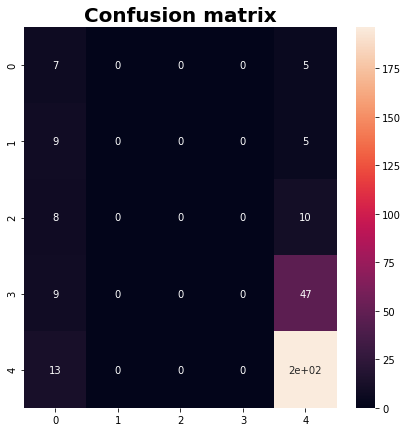

In [57]:
y_pred = han_model.predict(X_test)
evaluate_model(y_test, y_pred)

In [58]:
from tensorflow.keras import regularizers
class HAN_new(tf.keras.Model):
    """Hierarchical Attention Network implementation.

    Reference :
    * Hierarchical Attention Networks for Document Classification : https://www.cs.cmu.edu/~./hovy/papers/16HLT-hierarchical-attention-networks.pdf

    """
    def __init__(self, vocab_size, embedding_dim, gru_units, attention_units, classifier_units, pretrained_weights=None):
        """Hierarchical Attention Network class constructor.

        """
        super(HAN_new, self).__init__()
        
        if pretrained_weights is not None:
            initializer = tf.keras.initializers.Constant(pretrained_weights)
        else:
            initializer = "uniform"

        self.embedding = tf.keras.layers.Embedding(
            vocab_size, 
            embedding_dim, 
            embeddings_initializer=initializer,
            trainable=True
        )
        self.WordGRU = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units=gru_units,
                activation="tanh",
                dropout=0.4,    ###Recurrent dropout
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),  ##regularization
                return_sequences=True
            ), 
            merge_mode='concat',
        )
        self.WordAttention = Attention(units=attention_units)
        self.SentenceGRU = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units=gru_units,
                activation="tanh",
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),  ##regularization
                dropout=0.4,    ###Recurrent dropout
                return_sequences=True
            ), 
            merge_mode='concat',
        )
        self.SentenceAttention = Attention(units=attention_units)
        self.fc = tf.keras.layers.Dense(units=classifier_units,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),)##regularization
        self.dropout= tf.keras.layers.Dropout(rate=0.4)     ###Dropout layer

    def call(self, x):
        """Model forward method.
        """
        sentences_vectors, _ = self.word_to_sentence_encoder(x)
        document_vector, _ = self.sentence_to_document_encoder(sentences_vectors)
        return self.fc(document_vector)

    def word_to_sentence_encoder(self, x):
        """Given words from each sentences, 
           encode the contextual representation of the words from the sentence
           with Bidirectional GRU and Attention, and output a sentence_vector
        """
        x = self.embedding(x)
        x = tf.keras.layers.TimeDistributed(self.WordGRU)(x)
        x = self.dropout(x)   ###Dropout layer
        context_vector, attention_weights = self.WordAttention(x)

        return context_vector, attention_weights
    
    def document_encoder(self, sentences_vectors):
        sentences_vectors = self.SentenceGRU(sentences_vectors)
        sentences_vectors = self.dropout(sentences_vectors)   ###Dropout layer
        document_vector, attention_weights = self.SentenceAttention(sentences_vectors)
        
        return document_vector, attention_weights


In [59]:
han_model_new = HAN_new(
    vocab_size=max(tokenizer.index_word.keys())+1, 
    embedding_dim=128, 
    pretrained_weights=pretrained_weights, 
    gru_units=32, 
    attention_units=32, 
    classifier_units=5
)

In [61]:
sentences_vectors, word_wt = han_model_new.word_to_sentence_encoder(X_train)
document_vector, sentence_wt = han_model_new.document_encoder(sentences_vectors)

In [62]:
sents = [tokenizer.sequences_to_texts(x) for x in X_train]
ind_sen = [x.argmax() for x in sentence_wt.numpy()]

In [63]:
imp_sent_in_doc = [sents[i][ind_sen[i]] for i in range(len(X_train))]
imp_sent_in_doc[:10]

['', '', '', '', '', '', '', '', '', '']

In [64]:
ind_word = [[y.argmax() for y in s] for s in word_wt.numpy()]
word_imp = [[X_train[i][j][ind_word[i][j]] for j in range(10)] for i in range(len(X_train))]

In [65]:
imp_words_in_sent = [tokenizer.sequences_to_texts(word_imp)]
imp_words_in_sent[:10]

[['taste lovely',
  'spectacular',
  'always attitude',
  'sunday terrace',
  '',
  'wonderful spectacular made ’',
  'hotel',
  'bar hello',
  'dined three view west',
  'dinner booking',
  'view',
  'drinks helpful',
  'view night',
  'popstar',
  'view view',
  'view hotel good',
  'wine enjoy view fantastic completely',
  '',
  'good',
  'gem elegant throughout bar',
  'new available room',
  'view',
  'bar',
  'city good chef pear main ! bring black',
  '! cocktails !',
  'night',
  '! menu new ? honestly',
  'nice',
  'three friday skyline said',
  'drinks wait !',
  'husband ! even ! wait !',
  'come jerome',
  'good birthday',
  'location',
  '!',
  'super',
  'setting made even wait',
  'review',
  '',
  '! dinner especially',
  '!',
  '’ atmosphere underground …',
  'terrible mins ... always',
  '',
  'venue birthday phone',
  'town !',
  '! ! ! ! !',
  'cocktail bar ! …',
  'incredible tortellini ! ! !',
  'view',
  'wife ’ …',
  'view could jerome',
  'met complemented faul